# **Proyek Analisis Big Data - Fesmaro 2025**

## Import Libraries

In [1]:
# Standard libraries
import os
import re
import string
from multiprocessing import Pool
from collections import Counter

# Data processing and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import contractions

# NLTK for natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer

# Scikit-learn for feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harry\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#!pip freeze | grep -E "numpy|pandas|matplotlib|seaborn|nltk" > requirements.txt

In [3]:
#!cat requirements.txt

## Data Loading

### Dataset Information

- Dataset: Amazon Reviews
- Source: kritanjalijain/amazon-reviews
- Files: train.csv, test.csv
- Purpose: Binary sentiment classification (positive/negative)

In [4]:
#!pip install kagglehub

In [5]:
# import kagglehub
# amazon_reviews_path = kagglehub.dataset_download('kritanjalijain/amazon-reviews')

# # Load the pre-split train and test datasets
# df_train = pd.read_csv(f"{amazon_reviews_path}/train.csv")
# df_test = pd.read_csv(f"{amazon_reviews_path}/test.csv")

# # Verify the data
# print("Training data shape:", df_train.shape)
# print("Test data shape:", df_test.shape)

### Troubleshooting
- If you encounter a ModuleNotFoundError for kagglehub, run the installation command above.
- If you get authentication errors with kagglehub, ensure you have a Kaggle account and have set up your API credentials.
- For persistent loading issues, download the dataset manually from Kaggle and adjust the file paths accordingly.

In [6]:
df_train = pd.read_csv('./kaggle/input/amazon-reviews/train.csv')
df_test = pd.read_csv('./kaggle/input/amazon-reviews/test.csv')

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column                                                                                                                                                                                                                                                                                                                                                                                                      Dtype 
---  ------                                                                                                                                                                                                                                                                                                                                                                                                      ----- 
 0   2                                                                  

### Make columns name

In [8]:
df_train.columns = ['label', 'title', 'text']
df_test.columns = ['label', 'title', 'text']

### Change number of label

In [9]:
df_train['label'] = df_train['label'].map({1:0, 2:1})
df_test['label'] = df_test['label'].map({1:0, 2:1})

### Join the title with the text

In [10]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'text', 'title', 'text')
df_test = concat_columns(df_test, 'text', 'title', 'text')

## Exploratory Data Analysis (EDA)

### Basic Information

In [11]:
print(f"Dataset shape: {df_train.shape}")
print(f"Columns: {df_train.columns.tolist()}")
print("\nSample data:")
print(df_train.head())

Dataset shape: (3599999, 2)
Columns: ['label', 'text']

Sample data:
   label                                               text
0      1  I'm reading a lot of reviews saying that this ...
1      1  This soundtrack is my favorite music of all ti...
2      1  I truly like this soundtrack and I enjoy video...
3      1  If you've played the game, you know how divine...
4      1  I am quite sure any of you actually taking the...


### Check for missing values

In [12]:
print("\nMissing values:")
print(df_train.isnull().sum())


Missing values:
label    0
text     0
dtype: int64


In [13]:
print(df_train['label'].value_counts())
print(df_test['label'].value_counts())

label
0    1800000
1    1799999
Name: count, dtype: int64
label
0    200000
1    199999
Name: count, dtype: int64


### Class Distribution Analysis

Polarity:
- 0 for negative
- 1 for positive

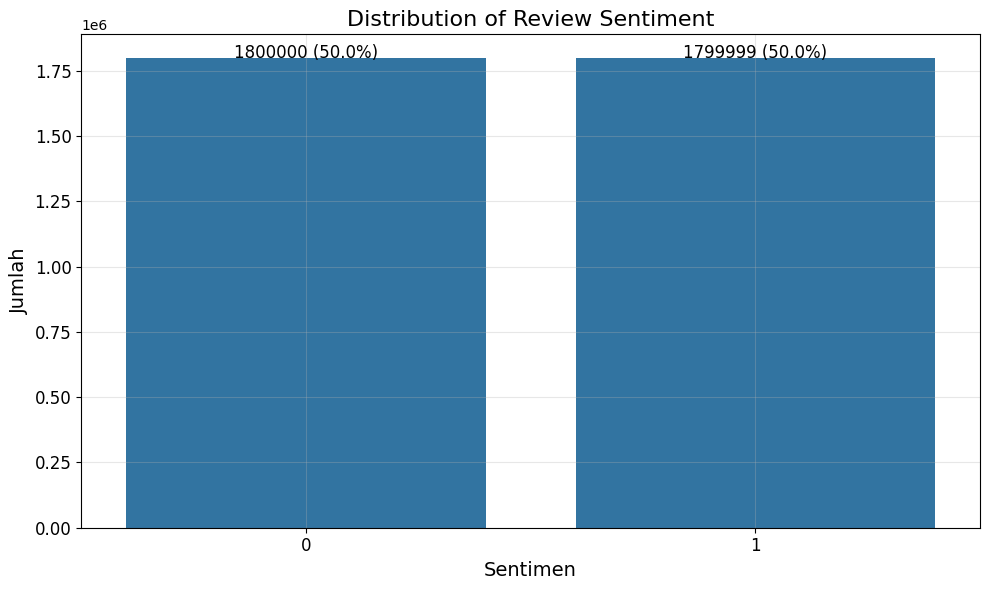

In [14]:
# Distribusi label sentimen
plt.figure(figsize=(10, 6))
sentiment_counts = df_train['label'].value_counts()
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Review Sentiment', fontsize=16)
plt.xlabel('Sentimen', fontsize=14)
plt.ylabel('Jumlah', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, alpha=0.3)

# Menambahkan nilai di atas bar
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v + 50, f"{v} ({v/sum(sentiment_counts.values):.1%})", 
             ha='center', fontsize=12)

plt.tight_layout()
plt.show()

### Text Length Analysis

In [15]:
# Count Text Length and Word Count
df_train['text_length'] = df_train['text'].apply(len)

print("\nText length statistics:")
print(df_train['text_length'].describe())


Text length statistics:
count    3.599999e+06
mean     4.306463e+02
std      2.375527e+02
min      7.100000e+01
25%      2.300000e+02
50%      3.820000e+02
75%      5.940000e+02
max      1.014000e+03
Name: text_length, dtype: float64


In [16]:
length_stats = df_train.groupby('label')[['text_length']].agg(['mean', 'median', 'min', 'max'])
print(length_stats)

      text_length                 
             mean median min   max
label                             
0      446.454255  404.0  88  1014
1      414.838378  359.0  71  1014


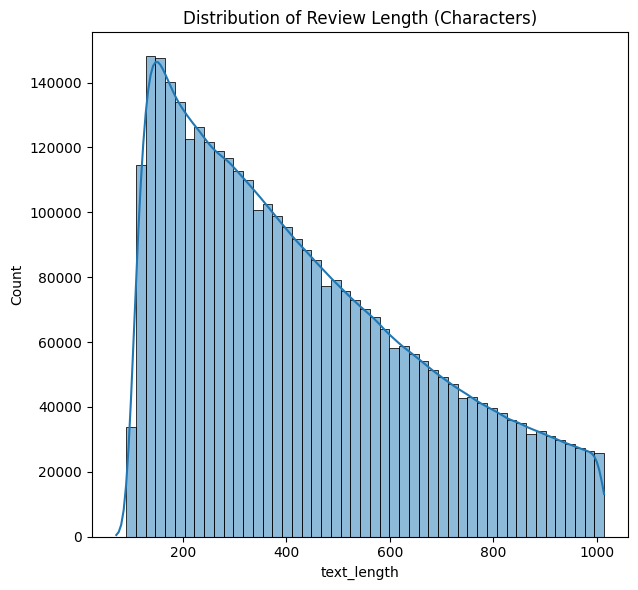

In [17]:
# Plot length distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_train['text_length'],kde=True, bins=50)
plt.title('Distribution of Review Length (Characters)')
plt.tight_layout()
plt.show()

### Word Frequency Analysis

In [18]:
# Word Count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))

print("\nWord count statistics:")
print(df_train['word_count'].describe())


Word count statistics:
count    3.599999e+06
mean     7.848273e+01
std      4.283281e+01
min      2.000000e+00
25%      4.200000e+01
50%      7.000000e+01
75%      1.080000e+02
max      2.570000e+02
Name: word_count, dtype: float64


In [19]:
length_stats = df_train.groupby('label')[['word_count']].agg(['mean', 'median', 'min', 'max'])
print(length_stats)

      word_count                
            mean median min  max
label                           
0      81.502666   74.0   2  257
1      75.462798   66.0   2  222


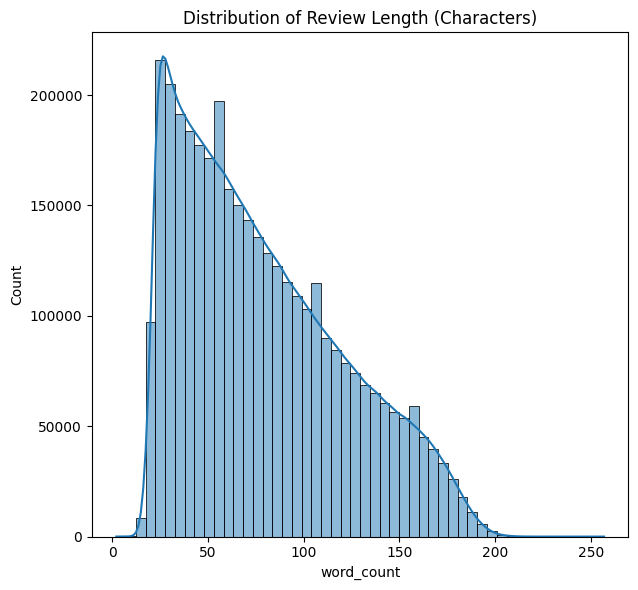

In [20]:
# Plot word count distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_train['word_count'],kde=True, bins=50)
plt.title('Distribution of Review Length (Characters)')
plt.tight_layout()
plt.show()

### Outlier and Anomaly Detection

#### Text Length

In [21]:
# Identifikasi outlier panjang review
q1_text = df_train['text_length'].quantile(0.25)
q3_text = df_train['text_length'].quantile(0.75)
iqr_text = q3_text - q1_text
lower_bound_text = q1_text - 1.5 * iqr_text
upper_bound_text = q3_text + 1.5 * iqr_text

outliers_text = df_train[(df_train['text_length'] < lower_bound_text) | (df_train['text_length'] > upper_bound_text)]
print(f"Jumlah outlier: {len(outliers_text)} ({len(outliers_text)/len(df_train):.2%} dari total)")

Jumlah outlier: 0 (0.00% dari total)


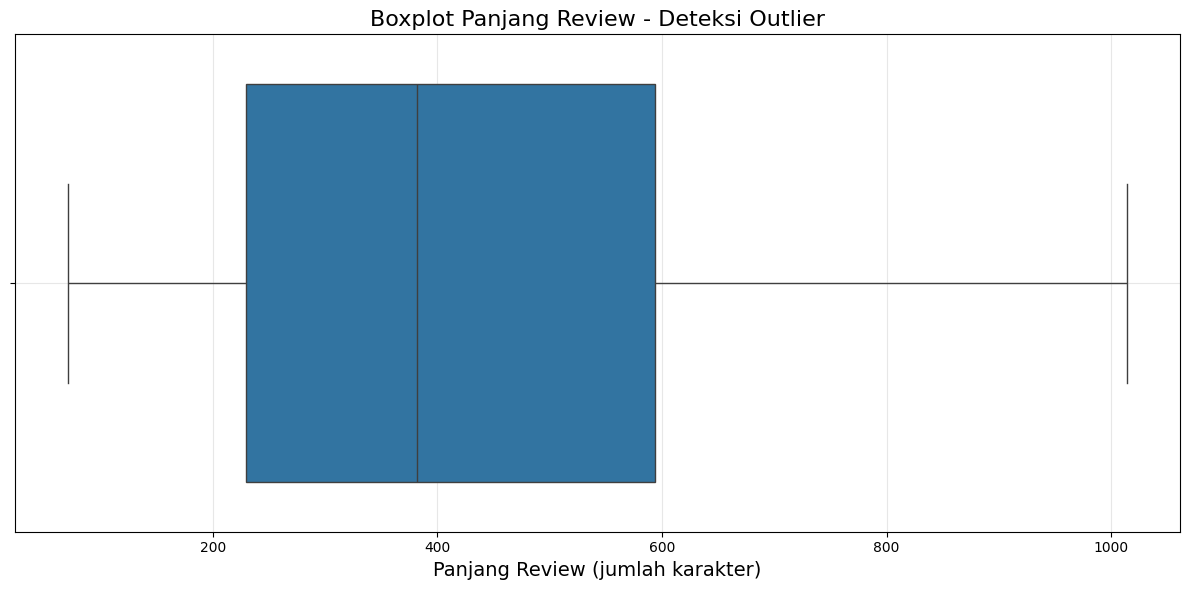

In [22]:
# Visualisasi
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_train['text_length'])
plt.title('Boxplot Panjang Review - Deteksi Outlier', fontsize=16)
plt.xlabel('Panjang Review (jumlah karakter)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
# Cek apakah ada outlier sebelum menampilkan sampel
if not outliers_text.empty:
    print(outliers_text.sample(5)[['text', 'text_length', 'label']])
else:
    print("Tidak ada outlier yang terdeteksi.")

Tidak ada outlier yang terdeteksi.


#### Word Count

In [24]:
# Identifikasi outlier panjang review
q1_word = df_train['word_count'].quantile(0.25)
q3_word = df_train['word_count'].quantile(0.75)
iqr_word = q3_word - q1_word
lower_bound_word = q1_word - 1.5 * iqr_word
upper_bound_word = q3_word + 1.5 * iqr_word

outliers_word = df_train[(df_train['word_count'] < lower_bound_word) | (df_train['word_count'] > upper_bound_word)]
print(f"Jumlah outlier: {len(outliers_word)} ({len(outliers_word)/len(df_train):.2%} dari total)")

Jumlah outlier: 221 (0.01% dari total)


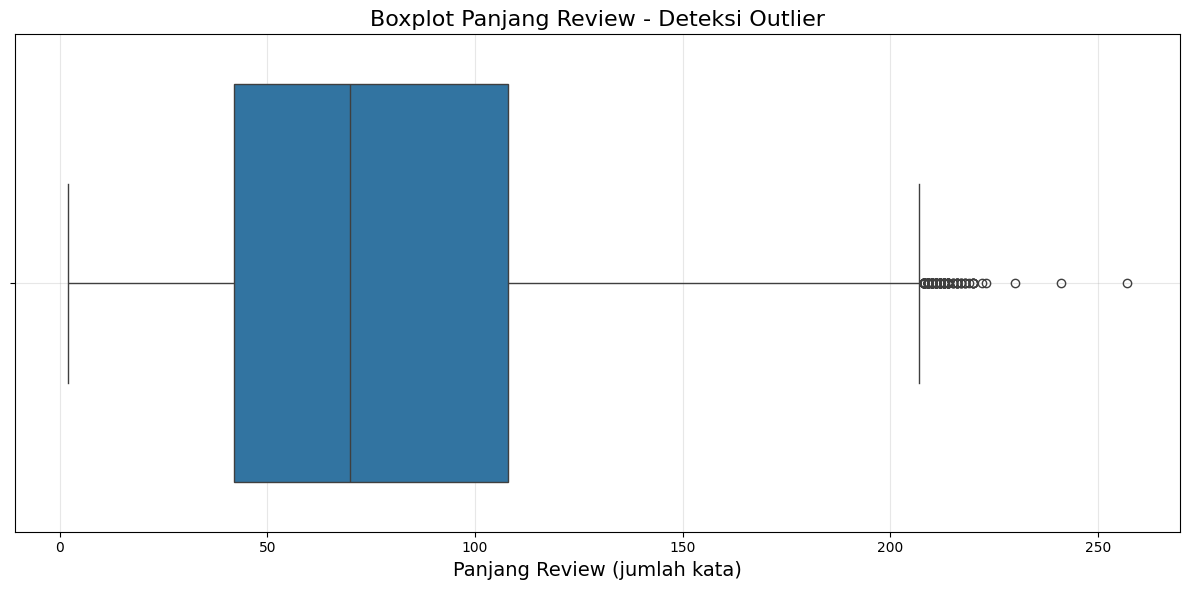

In [25]:
# Visualisasi
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_train['word_count'])
plt.title('Boxplot Panjang Review - Deteksi Outlier', fontsize=16)
plt.xlabel('Panjang Review (jumlah kata)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Cek apakah ada outlier sebelum menampilkan sampel
if not outliers_word.empty:
    print(outliers_word.sample(5)[['text', 'text_length', 'label']])
else:
    print("Tidak ada outlier yang terdeteksi.")


                                                      text  text_length  label
1416964  i wasnt shure to get this movie . i looked onc...          960      0
3324155  I bought this because it had a nice display an...         1010      0
3477814  When I first got this game it was great!! Then...          975      1
44956    Being a prog. house lover more so than trance ...         1010      1
3596667  I have brought many exercise dvds in my time t...         1006      1


## Data Preprocessing

### Sampling Data Train

In [27]:
# Filter data berdasarkan panjang teks dan jumlah kata terlebih dahulu
filtered_df_train = df_train[
    (df_train['text_length'] >= q1_text) & 
    (df_train['text_length'] <= q3_text) & 
    (df_train['word_count'] >= q1_word) & 
    (df_train['word_count'] <= q3_text)
]

# Sampling untuk data train dari data yang sudah difilter
# Ambil 50.000 sampel dari masing-masing label (jika tersedia)
train_label_0 = filtered_df_train[filtered_df_train['label'] == 0].sample(
    n=min(50000, len(filtered_df_train[filtered_df_train['label'] == 0])), 
    random_state=42
)
train_label_1 = filtered_df_train[filtered_df_train['label'] == 1].sample(
    n=min(50000, len(filtered_df_train[filtered_df_train['label'] == 1])), 
    random_state=42
)

# Gabungkan kedua sampel untuk dataset train
df_train_sampled = pd.concat([train_label_0, train_label_1])

# Acak urutan data
df_train = df_train_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
# Cek jumlah data hasil sampling
print("Jumlah data train setelah sampling:", len(df_train))
print("Distribusi label train:")
print(df_train['label'].value_counts())

Jumlah data train setelah sampling: 100000
Distribusi label train:
label
1    50000
0    50000
Name: count, dtype: int64


In [29]:
df_train.to_csv('data/df_train.csv', index=False)

### Sampling Data Validation

In [30]:
df_test['text_length'] = df_test['text'].apply(len)
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

In [31]:
# Filter data berdasarkan panjang teks dan jumlah kata terlebih dahulu
filtered_df_val = df_test[
    (df_test['text_length'] >= q1_text) & 
    (df_test['text_length'] <= q3_text) & 
    (df_test['word_count'] >= q1_word) & 
    (df_test['word_count'] <= q3_text)
]

# Sampling untuk data validation dari data yang sudah difilter
# Ambil 5.000 sampel dari masing-masing label (jika tersedia)
val_label_0 = filtered_df_val[filtered_df_val['label'] == 0].sample(
    n=min(5000, len(filtered_df_val[filtered_df_val['label'] == 0])), 
    random_state=369
)
val_label_1 = filtered_df_val[filtered_df_val['label'] == 1].sample(
    n=min(5000, len(filtered_df_val[filtered_df_val['label'] == 1])), 
    random_state=369
)

df_val_sampled = pd.concat([val_label_0, val_label_1])
df_val = df_val_sampled.sample(frac=1, random_state=369).reset_index(drop=True)

In [32]:
# Sampling untuk data test
# Ambil 10.000 sampel dari masing-masing label
val_label_0 = df_test[df_test['label'] == 0].sample(n=10000, random_state=369)
val_label_1 = df_test[df_test['label'] == 1].sample(n=10000, random_state=369)

# Gabungkan kedua sampel untuk dataset test
df_val = pd.concat([val_label_0, val_label_1])

# Acak urutan data
df_val = df_val.sample(frac=1, random_state=369).reset_index(drop=True)

In [33]:
print("\nJumlah data validation setelah sampling:", len(df_val))
print("Distribusi label test:")
print(df_val['label'].value_counts())


Jumlah data validation setelah sampling: 20000
Distribusi label test:
label
1    10000
0    10000
Name: count, dtype: int64


In [34]:
df_val.to_csv('data/df_val.csv', index=False)

### Sampling Data Test

In [35]:
# Filter data berdasarkan panjang teks dan jumlah kata terlebih dahulu
filtered_df_test = df_test[
    (df_test['text_length'] >= q1_text) & 
    (df_test['text_length'] <= q3_text) & 
    (df_test['word_count'] >= q1_word) & 
    (df_test['word_count'] <= q3_text)
]

# Sampling untuk data test dari data yang sudah difilter
# Ambil 10.000 sampel dari masing-masing label (jika tersedia)
test_label_0 = filtered_df_test[filtered_df_test['label'] == 0].sample(
    n=min(10000, len(filtered_df_test[filtered_df_test['label'] == 0])), 
    random_state=42
)
test_label_1 = filtered_df_test[filtered_df_test['label'] == 1].sample(
    n=min(10000, len(filtered_df_test[filtered_df_test['label'] == 1])), 
    random_state=42
)

df_test_sampled = pd.concat([test_label_0, test_label_1])
df_test = df_test_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [36]:
print("\nJumlah data test setelah sampling:", len(df_test))
print("Distribusi label test:")
print(df_test['label'].value_counts())


Jumlah data test setelah sampling: 20000
Distribusi label test:
label
1    10000
0    10000
Name: count, dtype: int64


In [37]:
df_test.to_csv('data/df_test.csv', index=False)

### Data Cleaning

In [38]:
def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    if isinstance(text, float):  # Handle NaN values
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Ekspansi kontraksi (don't -> do not)
    text = contractions.fix(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove user mentions (like @user)
    text = re.sub(r'@\w+', '', text)
    
    # Replace product model numbers and specific identifiers
    text = re.sub(r'\b[a-zA-Z0-9]{10,}\b', ' product ', text)
    
    # Replace numbers with 'number'
    text = re.sub(r'\d+', ' number ', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def remove_stopwords(text):
    """
    Remove stopwords while preserving negation words
    """
    stop_words = set(stopwords.words('english'))
    # Keep negation words as they're important for sentiment
    negation_words = {'no', 'not', 'nor', 'neither', "don't", "doesn't", "didn't", "wasn't", "weren't", "haven't", "hasn't", "hadn't", "can't", "couldn't", "shouldn't", "won't", "wouldn't", "isn't", "aren't"}
    stop_words = stop_words - negation_words
    
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    """
    Lemmatize text to reduce words to their base form
    """
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Optional function for stemming (often lemmatization is preferred for sentiment analysis)
def stem_text(text):
    """
    Stem words in text
    """
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(stemmed_tokens)

### Advanced Preprocessing Pipeline

In [39]:
# Create a copy of the original dataframe to preserve original data
df_processed = df_train.copy()

In [40]:
# Apply cleaning functions
print("Applying text cleaning...")
df_processed['cleaned_text'] = df_processed['text'].apply(clean_text)
df_processed['cleaned_no_stop'] = df_processed['cleaned_text'].apply(remove_stopwords)
df_processed['lemmatized_text'] = df_processed['cleaned_no_stop'].apply(lemmatize_text)

Applying text cleaning...


In [41]:
# Check the results
print("\nPreprocessing results sample:")
for i in range(3):  # Show first 3 examples
    print(f"\nOriginal: {df_processed['text'].iloc[i][:100]}...")
    print(f"Cleaned: {df_processed['cleaned_text'].iloc[i][:100]}...")
    print(f"Cleaned (no stopwords): {df_processed['cleaned_no_stop'].iloc[i][:100]}...")
    print(f"Lemmatized: {df_processed['lemmatized_text'].iloc[i][:100]}...")


Preprocessing results sample:

Original: i use this book constantly. the herbs are easy to access, the material gives easy to follow informat...
Cleaned: i use this book product the herbs are easy to access the material gives easy to follow product on ho...
Cleaned (no stopwords): use book product herbs easy access material gives easy follow product product herbs life excellent r...
Lemmatized: use book product herb easy access material give easy follow product product herb life excellent read...

Original: This CD is a great example of heavy hardcore with a softer edge - but not too soft. This band is a f...
Cleaned: this cd is a great example of heavy hardcore with a softer edge but not too soft this band is a few ...
Cleaned (no stopwords): cd great example heavy hardcore softer edge not soft band years old many bands days trying combine s...
Lemmatized: cd great example heavy hardcore softer edge not soft band year old many band day trying combine scre...

Original: I haven't read

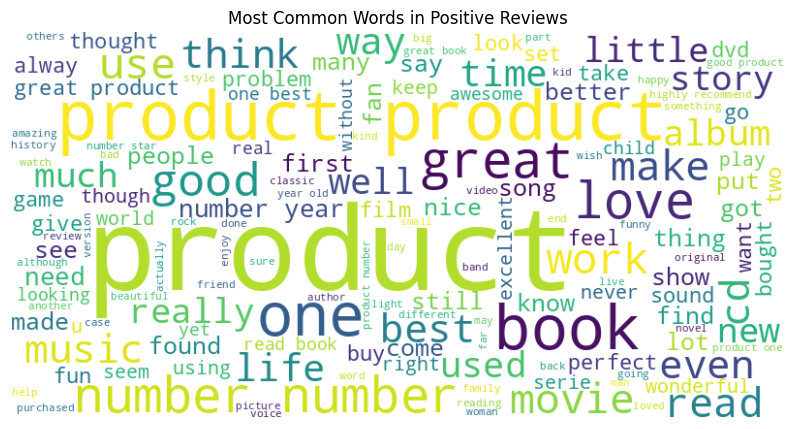

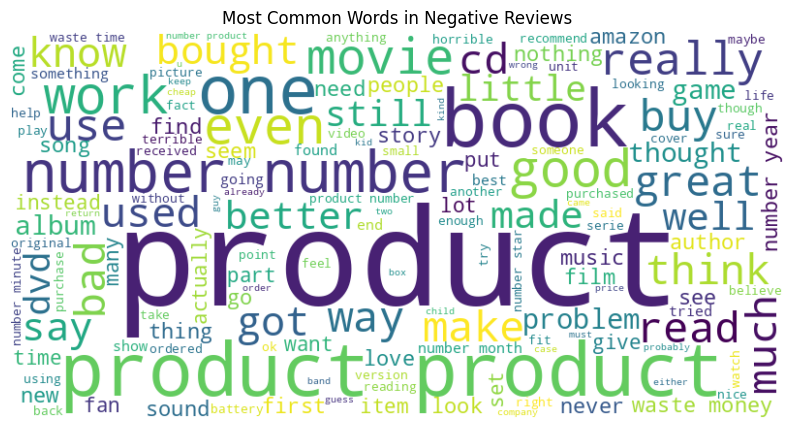

In [42]:
# Generate word clouds for each sentiment class
def generate_wordcloud(text_series, title):
    """Generate and display wordcloud"""
    all_text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=150).generate(all_text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# binary sentiment (e.g., positive=1, negative=0)
positive_reviews = df_processed[df_processed['label'] == 1]['lemmatized_text']
negative_reviews = df_processed[df_processed['label'] == 0]['lemmatized_text']

generate_wordcloud(positive_reviews, 'Most Common Words in Positive Reviews')
generate_wordcloud(negative_reviews, 'Most Common Words in Negative Reviews')

In [43]:
# Save processed data
df_processed.to_csv('data/df_processed.csv', index=False)

## Feature Engineering

In [44]:
df_processed = pd.read_csv('./data/df_processed.csv')

### Text-based

In [45]:
# Text-based feature engineering
df_processed['text_length'] = df_processed['text'].apply(len)
df_processed['word_count'] = df_processed['text'].apply(lambda x: len(str(x).split()))
df_processed['avg_word_length'] = df_processed['text'].apply(lambda x: np.mean([len(word) for word in str(x).split()]) if len(str(x).split()) > 0 else 0)
df_processed['exclamation_count'] = df_processed['text'].apply(lambda x: x.count('!'))
df_processed['question_count'] = df_processed['text'].apply(lambda x: x.count('?'))
df_processed['uppercase_word_count'] = df_processed['text'].apply(lambda x: sum(1 for word in x.split() if word.isupper() and len(word) > 1))
df_processed['uppercase_ratio'] = df_processed['uppercase_word_count'] / (df_processed['word_count'] + 1)  # +1 to avoid division by zero

In [46]:
# Sentiment-specific features
def count_positive_words(text):
    """Count appearance of common positive words"""
    positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'best', 'love', 'perfect', 'recommend', 'happy', 'awesome']
    return sum(1 for word in text.lower().split() if word in positive_words)

def count_negative_words(text):
    """Count appearance of common negative words"""
    negative_words = ['bad', 'poor', 'terrible', 'horrible', 'worst', 'waste', 'disappointed', 'disappointing', 'difficult', 'hate', 'problem', 'issue', 'fail']
    return sum(1 for word in text.lower().split() if word in negative_words)

df_processed['positive_word_count'] = df_processed['text'].apply(count_positive_words)
df_processed['negative_word_count'] = df_processed['text'].apply(count_negative_words)
df_processed['sentiment_word_ratio'] = (df_processed['positive_word_count'] + 1) / (df_processed['negative_word_count'] + 1)

### TF-IDF

In [47]:
# TF-IDF feature extraction (for n-grams)
print("Generating TF-IDF representations...")
tfidf_vectorizer = TfidfVectorizer(
    min_df=100,  # Minimum document frequency
    max_df=0.75,  # Maximum document frequency
    ngram_range=(1, 2),  # Use unigrams and bigrams
    max_features=10000  # Limit vocabulary size
)
tfidf_features = tfidf_vectorizer.fit_transform(df_processed['lemmatized_text'])

Generating TF-IDF representations...


In [48]:
# Show the most important TF-IDF features
feature_names = tfidf_vectorizer.get_feature_names_out()
print("\nTop TF-IDF features:")
for i, feature in enumerate(feature_names[:20]):
    print(f"{feature}")


Top TF-IDF features:
ability
able
able find
able get
able use
absolute
absurd
abuse
ac
academic
accent
accept
access
accident
according
account
accuracy
accurate
accurate product
achieve


### Final Data Preparation and Saving

In [49]:
# Create final dataset with selected features
# Choose the preprocessing level you prefer (cleaned_text, cleaned_no_stop, or lemmatized_text)
final_df = df_processed[['label', 'lemmatized_text', 'text_length', 'word_count', 'avg_word_length',
                        'exclamation_count', 'question_count', 'uppercase_ratio',
                        'positive_word_count', 'negative_word_count', 'sentiment_word_ratio']]

In [50]:
# Save processed data
final_df.to_csv('data/final_df.csv', index=False)

In [51]:
# Save TF-IDF features for later use (optional)
import pickle
with open('tfidf_features.pkl', 'wb') as f:
    pickle.dump({'features': tfidf_features, 'vectorizer': tfidf_vectorizer}, f)

print("Preprocessing complete! Data saved to 'final_df.csv'")

Preprocessing complete! Data saved to 'final_df.csv'


In [52]:
# Show summary statistics of the engineered features
print("\nEngineered features summary:")
print(final_df.describe())


Engineered features summary:
               label   text_length    word_count  avg_word_length  \
count  100000.000000  100000.00000  100000.00000    100000.000000   
mean        0.500000     394.28408      72.45959         4.473468   
std         0.500003     102.18181      18.98513         0.411110   
min         0.000000     230.00000      42.00000         2.486842   
25%         0.000000     306.00000      56.00000         4.190476   
50%         0.500000     385.00000      71.00000         4.434211   
75%         1.000000     478.00000      87.00000         4.712500   
max         1.000000     594.00000     127.00000         8.596154   

       exclamation_count  question_count  uppercase_ratio  \
count      100000.000000   100000.000000    100000.000000   
mean            0.920030        0.159090         0.020918   
std             2.648752        0.676051         0.087185   
min             0.000000        0.000000         0.000000   
25%             0.000000        0.000000   

## Modelling

In [53]:
final_df=pd.read_csv('./data/final_df.csv')
df_val=pd.read_csv('./data/df_val.csv')
df_test = pd.read_csv('./data/df_test.csv')

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
import spacy
from sklearn.metrics.pairwise import cosine_similarity
import os
import pickle

# Kelas untuk Graph Convolutional Network (GCN)
class GraphConvolution(nn.Module):
    """
    Layer konvolusi sederhana untuk GCN
    """
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def forward(self, input, adj):
        # input: [batch_size, seq_len, in_features]
        # adj: [batch_size, seq_len, seq_len]
        
        support = torch.bmm(input, self.weight.expand(input.size(0), -1, -1))
        output = torch.bmm(adj, support)
        
        if self.bias is not None:
            output = output + self.bias
        
        return output

# Model Fusion BERT+BiLSTM+GCN
class BERTBiLSTMGCNModel(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_dim=128, gcn_layers=2, 
                 lstm_layers=1, dropout=0.2, num_classes=2, linguistic_feat_dim=9):
        super(BERTBiLSTMGCNModel, self).__init__()
        
        # Inisialisasi BERT
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_dim = self.bert.config.hidden_size
        
        # Freeze BERT layers (opsional, untuk efisiensi training)
        # for param in self.bert.parameters():
        #     param.requires_grad = False
        
        # BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=self.bert_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0
        )
        
        # GCN layers
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(GraphConvolution(self.bert_dim, hidden_dim))
        for i in range(1, gcn_layers):
            self.gcn_layers.append(GraphConvolution(hidden_dim, hidden_dim))
        
        # Attention layer untuk weighted pooling
        self.attention = nn.Linear(hidden_dim * 2, 1)  # BiLSTM output dim = hidden_dim * 2
        
        # Classifier untuk BiLSTM
        self.bilstm_classifier = nn.Linear(hidden_dim * 2, hidden_dim)
        
        # Classifier untuk GCN
        self.gcn_classifier = nn.Linear(hidden_dim, hidden_dim)
        
        # Fitur linguistik processing
        self.linguistic_proj = nn.Linear(linguistic_feat_dim, hidden_dim)
        
        # Fusion layer dan classifier akhir
        self.fusion = nn.Linear(hidden_dim * 3, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_ids, attention_mask, adj_matrix, linguistic_features):
        # BERT forward pass
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_outputs.last_hidden_state  # [batch_size, seq_len, bert_dim]
        
        # BiLSTM forward pass
        lstm_output, _ = self.lstm(sequence_output)  # [batch_size, seq_len, hidden_dim*2]
        
        # Attention mechanism untuk BiLSTM
        attention_weights = F.softmax(self.attention(lstm_output), dim=1)
        lstm_pooled = torch.sum(attention_weights * lstm_output, dim=1)  # [batch_size, hidden_dim*2]
        
        # GCN forward pass
        gcn_output = sequence_output
        for gcn_layer in self.gcn_layers:
            gcn_output = F.relu(gcn_layer(gcn_output, adj_matrix))
        
        # Global max pooling untuk GCN
        gcn_pooled = torch.max(gcn_output, dim=1)[0]  # [batch_size, hidden_dim]
        
        # Process linguistic features
        ling_features = F.relu(self.linguistic_proj(linguistic_features))  # [batch_size, hidden_dim]
        
        # Projecting each component to same dimension
        bilstm_features = F.relu(self.bilstm_classifier(lstm_pooled))  # [batch_size, hidden_dim]
        gcn_features = F.relu(self.gcn_classifier(gcn_pooled))  # [batch_size, hidden_dim]
        
        # Fusion semua fitur
        combined = torch.cat([bilstm_features, gcn_features, ling_features], dim=1)  # [batch_size, hidden_dim*3]
        fused = F.relu(self.fusion(combined))  # [batch_size, hidden_dim]
        fused = self.dropout(fused)
        
        # Final classification
        logits = self.classifier(fused)  # [batch_size, num_classes]
        
        return logits

# Ekstraksi Fitur
class FeatureExtractor:
    def __init__(self, bert_model_name='bert-base-uncased', max_length=128, cache_dir=None):
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        self.nlp = spacy.load("en_core_web_sm")
        self.max_length = max_length
        self.cache_dir = cache_dir
        
        if cache_dir and not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
    
    def prepare_bert_inputs(self, texts, batch=True):
        """Tokenisasi texts untuk input ke BERT"""
        encodings = self.tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
        }
    
    def build_dependency_graph(self, text, use_cache=True):
        """Membuat graph berdasarkan dependency parsing"""
        if self.cache_dir and use_cache:
            # Create hash for caching
            import hashlib
            text_hash = hashlib.md5(text.encode()).hexdigest()
            cache_file = os.path.join(self.cache_dir, f"dep_graph_{text_hash}.pkl")
            
            if os.path.exists(cache_file):
                with open(cache_file, 'rb') as f:
                    return pickle.load(f)
        
        # Process with SpaCy (limit text length for efficiency)
        doc = self.nlp(text[:1000])
        
        # Get tokens (limited to max_length)
        tokens = [token.text.lower() for token in doc][:self.max_length]
        n = len(tokens)
        
        # Initialize adjacency matrix
        adjacency_matrix = np.zeros((self.max_length, self.max_length))
        
        # Fill adjacency matrix based on dependencies
        for token in doc:
            if token.i < n and token.head.i < n:
                # Add edge between token and its head
                adjacency_matrix[token.i, token.head.i] = 1
                adjacency_matrix[token.head.i, token.i] = 1
        
        # Add self-loops
        adjacency_matrix = adjacency_matrix + np.eye(self.max_length)
        
        # Normalize adjacency matrix (important for GCN)
        rowsum = np.array(adjacency_matrix.sum(1))
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = np.diag(d_inv_sqrt)
        normalized_adj = d_mat_inv_sqrt.dot(adjacency_matrix).dot(d_mat_inv_sqrt)
        
        result = torch.FloatTensor(normalized_adj)
        
        # Cache result if cache directory is provided
        if self.cache_dir and use_cache:
            with open(cache_file, 'wb') as f:
                pickle.dump(result, f)
        
        return result
    
    def extract_linguistic_features(self, text):
        """Ekstrak fitur linguistik untuk analisis sentimen"""
        features = {}
        
        # Text statistics
        features['text_length'] = min(len(text), 1000) / 1000  # Normalized length
        words = str(text).split()
        features['word_count'] = min(len(words), 200) / 200  # Normalized count
        features['avg_word_length'] = min(np.mean([len(word) for word in words]) if words else 0, 20) / 20
        
        # Sentiment indicators
        features['exclamation_count'] = min(text.count('!'), 10) / 10
        features['question_count'] = min(text.count('?'), 10) / 10
        features['uppercase_word_count'] = min(sum(1 for word in words if word.isupper() and len(word) > 1), 20) / 20
        features['uppercase_ratio'] = min(features['uppercase_word_count'] * 200 / (len(words) + 1), 1.0)
        
        # Sentiment lexicon features
        positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'best', 'love', 
                         'perfect', 'recommend', 'happy', 'awesome']
        negative_words = ['bad', 'poor', 'terrible', 'horrible', 'worst', 'waste', 'disappointed', 
                         'disappointing', 'difficult', 'hate', 'problem', 'issue', 'fail']
        
        features['positive_word_count'] = min(sum(1 for word in text.lower().split() if word in positive_words), 20) / 20
        features['negative_word_count'] = min(sum(1 for word in text.lower().split() if word in negative_words), 20) / 20
        features['sentiment_word_ratio'] = min((features['positive_word_count'] * 20 + 1) / 
                                            (features['negative_word_count'] * 20 + 1), 10) / 10
        
        return torch.FloatTensor([
            features['text_length'], 
            features['word_count'],
            features['avg_word_length'],
            features['exclamation_count'],
            features['question_count'],
            features['uppercase_ratio'],
            features['positive_word_count'],
            features['negative_word_count'],
            features['sentiment_word_ratio']
        ])
    
    def batch_extract_features(self, texts):
        """Ekstrak fitur untuk batch texts"""
        # Prepare BERT inputs
        bert_inputs = self.prepare_bert_inputs(texts)
        
        # Build dependency graphs
        adj_matrices = []
        for text in texts:
            adj_matrices.append(self.build_dependency_graph(text))
        adj_matrices = torch.stack(adj_matrices)
        
        # Extract linguistic features
        linguistic_features = []
        for text in texts:
            linguistic_features.append(self.extract_linguistic_features(text))
        linguistic_features = torch.stack(linguistic_features)
        
        return {
            'input_ids': bert_inputs['input_ids'],
            'attention_mask': bert_inputs['attention_mask'],
            'adj_matrices': adj_matrices,
            'linguistic_features': linguistic_features
        }

# Dataset yang menggunakan FeatureExtractor
class AmazonReviewDataset(Dataset):
    def __init__(self, reviews, labels, feature_extractor, precompute=False):
        self.reviews = reviews
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.precomputed_features = None
        
        if precompute:
            print("Precomputing features...")
            self.precomputed_features = self.feature_extractor.batch_extract_features(reviews)
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        if self.precomputed_features:
            features = {
                'input_ids': self.precomputed_features['input_ids'][idx].unsqueeze(0),
                'attention_mask': self.precomputed_features['attention_mask'][idx].unsqueeze(0),
                'adj_matrix': self.precomputed_features['adj_matrices'][idx].unsqueeze(0),
                'linguistic_features': self.precomputed_features['linguistic_features'][idx].unsqueeze(0),
                'label': torch.tensor(self.labels[idx], dtype=torch.long)
            }
        else:
            text = self.reviews[idx]
            label = self.labels[idx]
            
            # Extract features for single text
            bert_inputs = self.feature_extractor.prepare_bert_inputs([text], batch=False)
            adj_matrix = self.feature_extractor.build_dependency_graph(text)
            linguistic_features = self.feature_extractor.extract_linguistic_features(text)
            
            features = {
                'input_ids': bert_inputs['input_ids'],
                'attention_mask': bert_inputs['attention_mask'],
                'adj_matrix': adj_matrix.unsqueeze(0),
                'linguistic_features': linguistic_features.unsqueeze(0),
                'label': torch.tensor(label, dtype=torch.long)
            }
        
        return features

# Fungsi training dan evaluasi
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        adj_matrix = batch['adj_matrix'].to(device)
        linguistic_features = batch['linguistic_features'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, adj_matrix, linguistic_features)
        loss = criterion(outputs, labels)
        
        # Backward pass dan update
        loss.backward()
        optimizer.step()
        
        # Metrics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return epoch_loss / len(dataloader), accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            adj_matrix = batch['adj_matrix'].to(device)
            linguistic_features = batch['linguistic_features'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(input_ids, attention_mask, adj_matrix, linguistic_features)
            loss = criterion(outputs, labels)
            
            # Metrics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return epoch_loss / len(dataloader), accuracy

# Fungsi main untuk training
def train_model(train_reviews, train_labels, val_reviews, val_labels, 
                epochs=5, batch_size=16, learning_rate=2e-5, cache_dir='./feature_cache'):
    
    # Inisialisasi feature extractor
    feature_extractor = FeatureExtractor(cache_dir=cache_dir)
    
    # Buat dataset
    train_dataset = AmazonReviewDataset(train_reviews, train_labels, feature_extractor)
    val_dataset = AmazonReviewDataset(val_reviews, val_labels, feature_extractor)
    
    # Buat dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Inisialisasi model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BERTBiLSTMGCNModel().to(device)
    
    # Optimizer dan loss
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop
    best_val_acc = 0
    
    for epoch in range(epochs):
        # Training
        train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, criterion, device)
        
        # Validation
        val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model!")
    
    return model

# Fungsi untuk batch processing pada dataset besar
def process_large_dataset(reviews, labels, batch_size=10000, cache_dir='./feature_cache'):
    """
    Process dataset besar dengan batch untuk menghindari bottleneck memori
    """
    feature_extractor = FeatureExtractor(cache_dir=cache_dir)
    
    for i in range(0, len(reviews), batch_size):
        end_idx = min(i + batch_size, len(reviews))
        batch_reviews = reviews[i:end_idx]
        batch_labels = labels[i:end_idx]
        
        print(f"Processing batch {i//batch_size + 1}/{len(reviews)//batch_size + 1}")
        
        # Extract and cache features
        batch_features = feature_extractor.batch_extract_features(batch_reviews)
        
        # Save features
        torch.save({
            'input_ids': batch_features['input_ids'],
            'attention_mask': batch_features['attention_mask'],
            'adj_matrices': batch_features['adj_matrices'],
            'linguistic_features': batch_features['linguistic_features'],
            'labels': torch.tensor(batch_labels, dtype=torch.long)
        }, f"{cache_dir}/batch_{i//batch_size}.pt")
        
    print("Preprocessing complete!")

# Contoh kode untuk penggunaan model
def example_usage():
    # Contoh data dummy
    train_reviews = [
        "This product is amazing! I love it and would definitely recommend.",
        "Terrible experience. The item arrived broken and customer service was unhelpful.",
        "Good product for the price. It works as advertised."
    ]
    train_labels = [1, 0, 1]  # 1 = positive, 0 = negative
    
    val_reviews = [
        "Not worth the money. Stopped working after a week.",
        "Great value and excellent quality. Very satisfied with my purchase."
    ]
    val_labels = [0, 1]
    
    # Train model
    model = train_model(train_reviews, train_labels, val_reviews, val_labels, epochs=2)
    
    # Untuk dataset besar
    # process_large_dataset(all_reviews, all_labels)
    
    print("Training complete!")

if __name__ == "__main__":
    example_usage()

ValueError: too many values to unpack (expected 2)

## Evaluation

## pip freeze | grep -E "numpy|pandas|matplotlib|seaborn"Testing